In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import funcionalidade as fc
from pylift import TransformedOutcome
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from optbinning import OptimalBinning
from optbinning import BinningProcess
import acessos as ac

(CVXPY) Mar 30 11:59:17 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 30 11:59:17 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
inativos = pd.read_pickle('inativos_fatura_premiada.pkl')

inativos['grupo'] = [0 if x == 'Sem comunicação' else 1 for x in inativos['grupo_comunicacao']]

In [3]:
#conversao
inativos_c = fc.traz_conversao('flavia-costa', '2023-03-17', '2023-03-24', 'cpf', inativos)

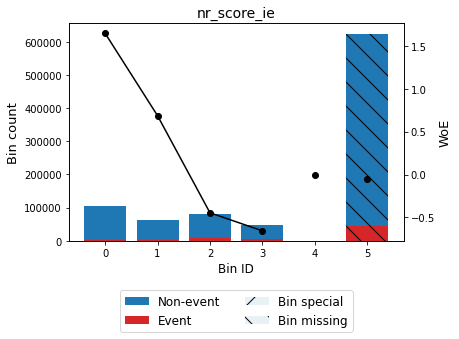

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.19214808
    IV (Jeffrey)             0.23540193
    JS (Jensen-Shannon)      0.02730086
    Hellinger                0.02830044
    Triangular               0.10242167
    KS                       0.13128925
    HHI                      0.49247206
    HHI (normalized)         0.39096647
    Cramer's V               0.18854106
    Quality score            0.50044363

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value     P[A > B]  P[B > A]
        0      1   835.804334 8.866754e-184 0.000000e+00       1.0
        1      2  2267.867683  0.000000e+00 0.000000e+00       1.0
        2      3   131.039990  2.426681e-30 8.660463e-54       1.0



In [4]:
#aplicar algoritmo de bin otimizado para dar resultado

variable_names = ['nr_score_ie']


binning_process = BinningProcess(variable_names=variable_names)
binning_process.fit(inativos_c[variable_names], inativos_c['converteu'])

for i in variable_names:
    optb = binning_process.get_binned_variable(name=i)
    optb.binning_table.build()
    optb.binning_table.plot()
    optb.binning_table.analysis()



#http://gnpalencia.org/optbinning/tutorials/tutorial_binary.html

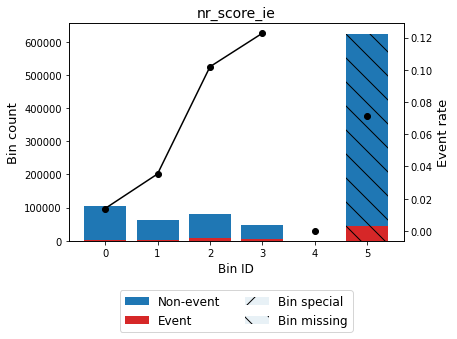

In [5]:
optb.binning_table.plot(metric="event_rate")

In [6]:
#caso queiramos transformar como nova variável
optb = OptimalBinning(name='nr_score_ie', dtype="numerical", solver="cp")
optb.fit(inativos_c['nr_score_ie'].values, inativos_c['converteu'].values)
   

OptimalBinning(name='nr_score_ie')

In [7]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3.24)",104073,0.113575,102635,1438,0.013817,1.645269,0.159519,0.017957
1,"[3.24, 9.43)",61298,0.066895,59134,2164,0.035303,0.685191,0.023525,0.002884
2,"[9.43, 22.92)",79314,0.086555,71235,8079,0.101861,-0.44594,0.020896,0.002591
3,"[22.92, inf)",46795,0.051067,41053,5742,0.122705,-0.6556,0.029182,0.003584
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,624858,0.681908,580250,44608,0.071389,-0.057111,0.002280,0.000285
Totals,,916338,1.000000,854307,62031,0.067694,,0.235402,0.027301


In [8]:
inativos_c['fx_ie'] = np.where(inativos_c['nr_score_ie'] <= 3.24, 1,
                             np.where(inativos_c['nr_score_ie'] <= 9.43, 2,
                                      np.where(inativos_c['nr_score_ie'] <= 22.92, 3, 4)))

In [9]:
inativos_c['fx_ie'].value_counts()

4    671653
1    104073
3     79314
2     61298
Name: fx_ie, dtype: int64

In [12]:
import funcionalidade as fc

inativos_c['grupo'] = ['controle' if x == 'Sem comunicação' else 'alvo' for x in inativos_c['grupo_comunicacao']]

for x in range(1,5):
    temp_df = pd.DataFrame()
    print(f"=============Faixa de IE: {x}============")
    temp_df = inativos_c[inativos_c['fx_ie'] == x]
    fc.testes_iterativos(temp_df)

=============Faixa de IE: 1============
          grupo converteu    spending            transacoes        
          count      mean        mean        sum       mean     sum
grupo                                                              
alvo      94478  0.013802  475.275491  619759.24   2.791411  3640.0
controle   9595  0.013966  386.942015   51850.23   2.671642   358.0
_____________________
Lift da conversão: -1.17%
Estatística t do teste de diferença de proporções: -0.13
P-valor do teste de diferença de proporções: 0.896027
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 22.83%
Estatística t do teste de spending: 0.94
P-valor do teste de spending: 0.348489
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 4.48%
Estatística t do teste de frequencia: 0.23
P-valor do teste de frequencia: 0.817032
A diferen

In [13]:
optb = OptimalBinning(name='segmento_mcc_agg', dtype="categorical", solver="cp")
optb.fit(inativos_c['segmento_mcc_agg'].values, inativos_c['converteu'].values)
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[0 - OUTROS, 5 - LOJAS ESPECIALIZADAS, 3 - SER...",916338,1.0,854307,62031,0.067694,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,916338,1.0,854307,62031,0.067694,,0.0,0.0


In [14]:
personas = ac.df_athena_q('flavia-costa', 
                          """select 
                                cpf
                                , max(ds_cluster_sociodemographic) as ds_cluster_sociodemographic
                                from customer_curated_zone.ca_book_cliente_cluster cl
                                left join customer_curated_zone.ca_book_cliente ci on (ci.id_customer = cl.id_customer)
                                group by 1 """)

inativos_p = inativos_c.join(personas.set_index('cpf'), how = 'left', on = 'cpf')

In [15]:
inativos_p['grupo'] = [0 if x == 'Sem comunicação' else 1 for x in inativos_p['grupo_comunicacao']]


In [16]:
for column in inativos_p.columns:
  if inativos_p[column].dtype == 'object':
    inativos_p[column].fillna(inativos_p[column].mode()[0], inplace = True)
  elif inativos_p[column].dtype != 'object':
    inativos_p[column].fillna(inativos_p[column].median(), inplace = True)

In [17]:
inativos_p['ds_cluster_sociodemographic'] = np.where(inativos_p['ds_cluster_sociodemographic'] == None, inativos_p['ds_cluster_sociodemographic'].mode()[0], inativos_p['ds_cluster_sociodemographic'])
inativos_p['ds_cluster_sociodemographic'] = inativos_p['ds_cluster_sociodemographic'].astype('string')

In [18]:
inativos_p['cluster_persona'] = inativos_p['ds_cluster_sociodemographic'].str[0:2]
inativos_p['cluster_persona'] = inativos_p['cluster_persona'].astype('int')

In [19]:
clf = LogisticRegression()
up = TransformedOutcome(inativos_p.query('nr_score_ie >= 0')[['grupo', 'converteu', 'nr_score_ie','segmento_mcc_agg','cluster_persona']], col_treatment='grupo', col_outcome='converteu', sklearn_model=LogisticRegression)

<AxesSubplot:xlabel='NIV', ylabel='Features'>

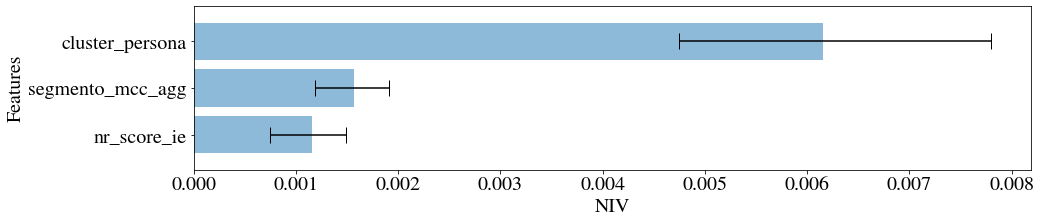

In [20]:
up.NIV()

<AxesSubplot:title={'center':'NWOE by bin for cluster_persona'}, xlabel='Bin Interval'>

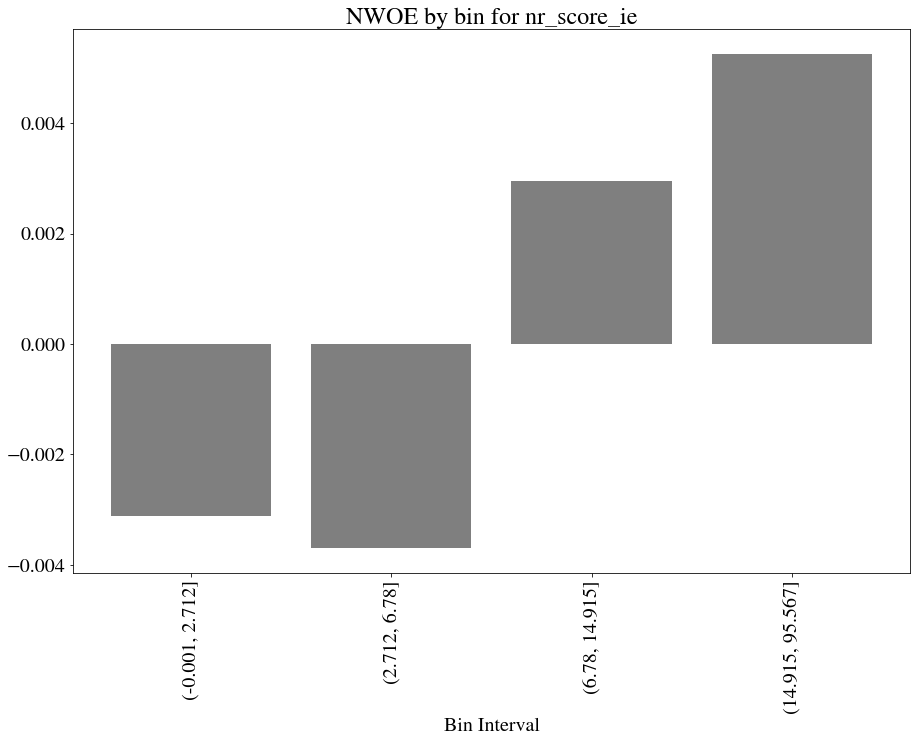

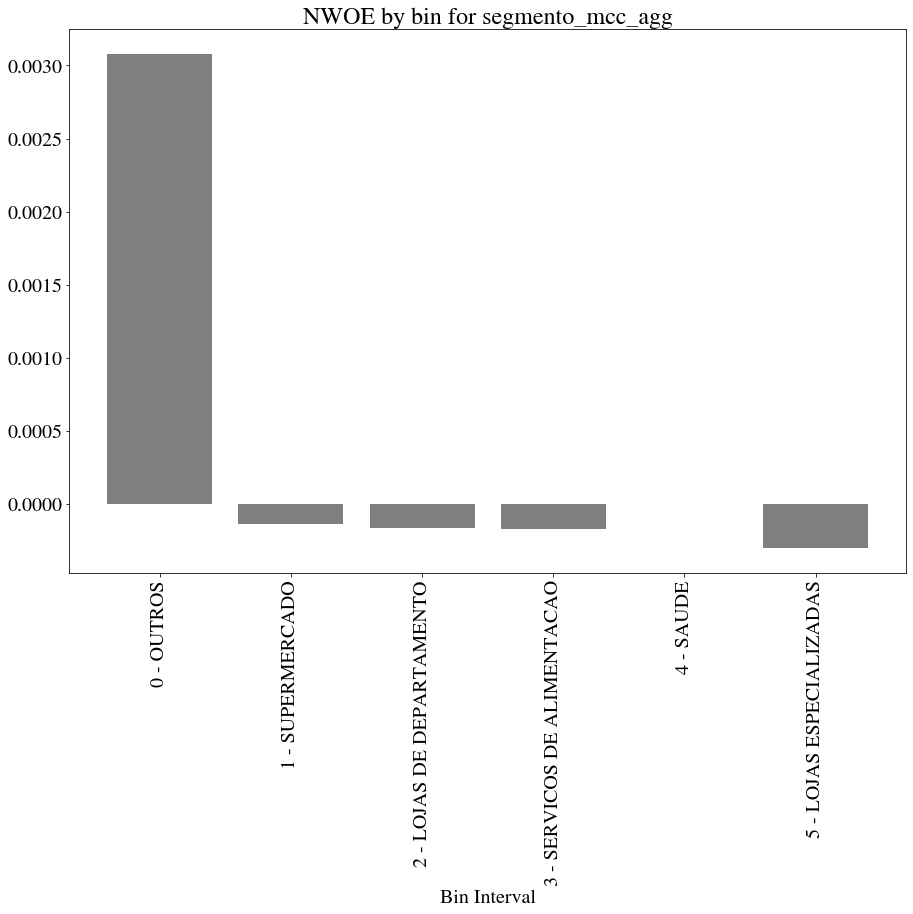

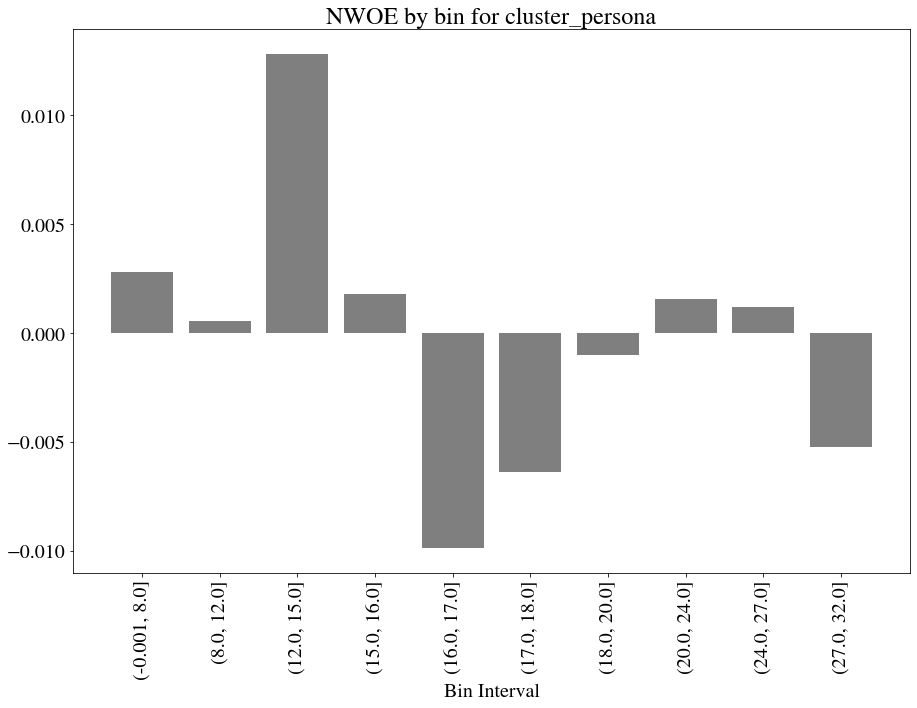

In [21]:
up.NWOE()

In [26]:
print(inativos_p.query('cluster_persona >= 12 & cluster_persona <= 15')['ds_cluster_sociodemographic'].unique())

<StringArray>
[                                            '14 - Homem, Casado, 35 anos ou mais, cidade Pequena do Nordeste',
                                                                         '15 - Mulher, 25 a 40 anos, Nordeste',
 '12 - Mulher, Solteira, 35 anos ou mais, cidade Pequena do Nordeste, ensino fundamental cursando ou completo',
                                '13 - Homem, Solteiro, 35 anos ou mais, cidade Média do Norte ou Centro-Oeste']
Length: 4, dtype: string
